# Partnership Engineering x 42Roma Luiss
# Lab AI su progetti tecnici: Problema del ROBOT


## Problema:
Il problema si basa su dati provenienti da robot che eseguono cicli di lavorazione e consiste nel trovare un modo semplice e non supervisionato per distinguere i cicli in termini di stati di funzionamento normali e stati di funzionamento anomali.

### Dati:
- Ogni ciclo di lavorazione e' rappresentato da un dataset;
- I dataset sono organizzati in cinque gruppi: uno per i file robot generati in condizioni nominali, tre per condizioni anomale specifiche (oil leakage, no payload e dry bearing) e un quarto per i test;
- I record raccolgono ogni due secondi i valori delle correnti date ai motori dei bracci e le loro posizioni assunte;
- Altri dati sono il tipo di log, la marca temporale e l'identificativo del ciclo di lavorazione.

### Soluzione proposta:
La soluzione che proponiamo e' un algoritmo basato sul modello di Clustering del KMeans: l'algoritmo suddivide i cicli di lavorazione del robot in 4 cluster, uno per il funzionamento in caso normale e tre per il funzionamento in caso anomalo.

Delle 12 variabili presenti nei record sono state ritenute rilevanti per l'analisi del problema solo le 6 variabili delle correnti dei bracci. Da queste 6 correnti e' stata poi eliminata anche la corrente I1 in quanto ritenuta poco significativa rispetto alle altre correnti. Infine, su queste rimanenti 5 features sono state calcolate le grandezze statistiche della media, della deviazione standard (per tutte le correnti apparte I1), del range max-min (corrente I4), della kurtosis (corrente I4) e della skewness (corrente I2).

Su queste 5 grandezze statistiche e' stato poi applicato il modello KMeans.

## Implementazione:

Import di tutte le librerie necessarie e setting delle impostazioni

In [384]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# General settings
np.set_printoptions(precision=4, suppress=True)
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

# Setting of parameters
plt.rcParams['figure.figsize'] = (16,10)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

### Import di tutti i dataset

Nominal

In [385]:
folder_path = './rawData/nominal/'
column_names = ['Current_arm1', 'Current_arm2', 'Current_arm3', 'Current_arm4', 'Current_arm5', 'Current_arm6', 'Position_arm1', 'Position_arm2', 'Position_arm3', 'Position_arm4', 'Position_arm5', 'Position_arm6', 'Log_type', 'timestamp', 'Working_cycle']

df = pd.DataFrame()

files = os.listdir(folder_path)

for file in files:
	file_path = os.path.join(folder_path, file)
	dftmp = pd.read_csv(file_path, sep=';', header=None, names=column_names)
	df = pd.concat([df, dftmp], ignore_index=True)

Oil leakage

In [386]:
folder_path = './rawData/Oil leakage/'
column_names = ['Current_arm1', 'Current_arm2', 'Current_arm3', 'Current_arm4', 'Current_arm5', 'Current_arm6', 'Position_arm1', 'Position_arm2', 'Position_arm3', 'Position_arm4', 'Position_arm5', 'Position_arm6', 'Log_type', 'timestamp', 'Working_cycle']

df1 = pd.DataFrame()

files = os.listdir(folder_path)

for file in files:
	file_path = os.path.join(folder_path, file)
	df1tmp = pd.read_csv(file_path, sep=';', header=None, names=column_names)
	df1 = pd.concat([df1, df1tmp], ignore_index=True)

No payload

In [387]:
folder_path = './rawData/noPayload/'
column_names = ['Current_arm1', 'Current_arm2', 'Current_arm3', 'Current_arm4', 'Current_arm5', 'Current_arm6', 'Position_arm1', 'Position_arm2', 'Position_arm3', 'Position_arm4', 'Position_arm5', 'Position_arm6', 'Log_type', 'timestamp', 'Working_cycle']

df2 = pd.DataFrame()

files = os.listdir(folder_path)

for file in files:
	file_path = os.path.join(folder_path, file)
	df2tmp = pd.read_csv(file_path, sep=';', header=None, names=column_names)
	df2 = pd.concat([df2, df2tmp], ignore_index=True)

Dry bearing


In [388]:

folder_path = './rawData/dryBearing/'
column_names = ['Current_arm1', 'Current_arm2', 'Current_arm3', 'Current_arm4', 'Current_arm5', 'Current_arm6', 'Position_arm1', 'Position_arm2', 'Position_arm3', 'Position_arm4', 'Position_arm5', 'Position_arm6', 'Log_type', 'timestamp', 'Working_cycle']

df3 = pd.DataFrame()

files = os.listdir(folder_path)

for file in files:
	file_path = os.path.join(folder_path, file)
	df3tmp = pd.read_csv(file_path, sep=';', header=None, names=column_names)
	df3 = pd.concat([df3, df3tmp], ignore_index=True)

Test

In [389]:
folder_path = './rawData/test/'
column_names = ['Current_arm1', 'Current_arm2', 'Current_arm3', 'Current_arm4', 'Current_arm5', 'Current_arm6', 'Position_arm1', 'Position_arm2', 'Position_arm3', 'Position_arm4', 'Position_arm5', 'Position_arm6', 'Log_type', 'timestamp', 'Working_cycle']

dfTest = pd.DataFrame()

files = os.listdir(folder_path)

for file in files:
	file_path = os.path.join(folder_path, file)
	dfTesttmp = pd.read_csv(file_path, sep=';', header=None, names=column_names)
	dfTest = pd.concat([dfTest, dfTesttmp], ignore_index=True)

### Creazione dei dataframe per l'analisi delle variabili

In [390]:
# Definizione dei dataframe
dataframes = [df, df1, df2, df3]
names = ['df', 'df1', 'df2', 'df3']

# Eliminazione della colonna 'timestamp' dai vari dataframe
df.drop(columns=['timestamp'], inplace=True)
df1.drop(columns=['timestamp'], inplace=True)
df2.drop(columns=['timestamp'], inplace=True)
df3.drop(columns=['timestamp'], inplace=True)

# Calcolo di alcune grandezze statistiche di ogni dataframe
mean_dict = {}
std_dict = {}
min_dict = {}
max_dict = {}
range_dict = {}
median_dict = {}
kurtosis_dict = {}
skewness_dict = {}

for name, dataframe in zip(names, dataframes):
    mean_dict[name] = dataframe.mean()
    std_dict[name] = dataframe.std()
    min_dict[name] = dataframe.min()
    max_dict[name] = dataframe.max()
    range_dict[name] = dataframe.max() - dataframe.min()
    median_dict[name] = dataframe.median()
    kurtosis_dict[name] = dataframe.kurt()
    skewness_dict[name] = dataframe.skew()

# Creazione di un dataframe per ogni feature calcolata
mean_df = pd.DataFrame(mean_dict)
std_df = pd.DataFrame(std_dict)
min_df = pd.DataFrame(min_dict)
max_df = pd.DataFrame(max_dict)
range_df = pd.DataFrame(range_dict)
median_df = pd.DataFrame(median_dict)
kurtosis_df = pd.DataFrame(kurtosis_dict)
skewness_df = pd.DataFrame(skewness_dict)

# Media
print("Side-by-Side Comparison of Mean:")
display(mean_df)

# Deviazione standard
print("\nSide-by-Side Comparison of Standard Deviation:")
display(std_df)

# Min e max
print("\nSide-by-Side Comparison of Min:")
display(min_df)
print("\nSide-by-Side Comparison of Max:")
display(max_df)

# Range max-min
print("\nSide-by-Side Comparison of Range:")
display(range_df)

# Mediana
print("\nSide-by-Side Comparison of Median:")
display(median_df)

# Kurtosis
print("\nSide-by-Side Comparison of Kurtosis:")
display(kurtosis_df)

# Skewness
print("\nSide-by-Side Comparison of Skewness:")
display(skewness_df)

Side-by-Side Comparison of Mean:


,df,df1,df2,df3
Current_arm1,0.02318,0.07265,0.07299,0.06564
Current_arm2,6.88177,2.49607,2.85499,2.82578
Current_arm3,6.12424,2.07919,2.07670,2.07929
Current_arm4,0.19820,0.17355,0.17291,0.17645
Current_arm5,-1.02938,0.16114,0.16137,0.15549
Current_arm6,-0.22546,0.01066,0.01108,0.01028
Position_arm1,-11.42989,-11.09037,-11.03205,-11.13059
Position_arm2,-18.12738,-18.33179,-18.36498,-18.30689
Position_arm3,-56.47592,-56.83650,-56.75719,-56.88455
Position_arm4,-43.92329,-43.75049,-43.76357,-43.74140



Side-by-Side Comparison of Standard Deviation:


,df,df1,df2,df3
Current_arm1,4.11266,2.75751,2.76303,2.74863
Current_arm2,6.61873,6.28960,4.90750,4.88045
Current_arm3,4.25991,3.79888,3.80210,3.79272
Current_arm4,2.20881,1.01212,1.01363,1.22801
Current_arm5,0.92331,0.88830,0.89001,0.88477
Current_arm6,0.73673,0.62745,0.62873,0.62528
Position_arm1,21.85774,21.85393,21.83655,21.85368
Position_arm2,9.88144,9.88692,9.86957,9.89655
Position_arm3,22.95953,22.97184,22.96046,22.96991
Position_arm4,3.92431,3.94009,3.93847,3.93816



Side-by-Side Comparison of Min:


,df,df1,df2,df3
Current_arm1,-20.80370,-12.66190,-12.62010,-12.69510
Current_arm2,-17.58740,-20.09080,-15.29590,-15.31340
Current_arm3,-18.00870,-17.04360,-17.00200,-17.00190
Current_arm4,-5.42730,-3.12530,-3.11590,-3.56700
Current_arm5,-4.00140,-2.50330,-2.50560,-2.50930
Current_arm6,-2.18730,-2.16380,-2.13520,-2.14210
Position_arm1,-44.17930,-43.85300,-43.85300,-43.85300
Position_arm2,-29.22850,-29.44680,-29.44670,-29.44670
Position_arm3,-101.65900,-102.02640,-102.02640,-102.02640
Position_arm4,-56.75800,-56.67750,-56.67760,-56.67760



Side-by-Side Comparison of Max:


,df,df1,df2,df3
Current_arm1,18.98250,12.81710,12.77550,12.81180
Current_arm2,32.83490,30.40710,25.99760,25.99870
Current_arm3,23.70510,17.87250,17.82140,17.81420
Current_arm4,9.72770,3.87160,3.90290,4.35220
Current_arm5,2.51620,2.56110,2.56080,2.55930
Current_arm6,2.54340,1.79860,1.79990,1.80190
Position_arm1,6.63080,6.95750,6.95750,6.95750
Position_arm2,4.06280,3.86320,3.86020,3.86020
Position_arm3,-34.29690,-34.66100,-34.66100,-34.66090
Position_arm4,-37.23480,-37.06060,-37.06070,-37.05940



Side-by-Side Comparison of Range:


,df,df1,df2,df3
Current_arm1,39.78620,25.47900,25.39560,25.50690
Current_arm2,50.42230,50.49790,41.29350,41.31210
Current_arm3,41.71380,34.91610,34.82340,34.81610
Current_arm4,15.15500,6.99690,7.01880,7.91920
Current_arm5,6.51760,5.06440,5.06640,5.06860
Current_arm6,4.73070,3.96240,3.93510,3.94400
Position_arm1,50.81010,50.81050,50.81050,50.81050
Position_arm2,33.29130,33.31000,33.30690,33.30690
Position_arm3,67.36210,67.36540,67.36540,67.36550
Position_arm4,19.52320,19.61690,19.61690,19.61820



Side-by-Side Comparison of Median:


,df,df1,df2,df3
Current_arm1,-0.17520,-0.01690,-0.01490,-0.02360
Current_arm2,9.21710,4.79495,3.67170,3.60430
Current_arm3,5.25040,0.59290,0.59300,0.58280
Current_arm4,-0.77580,0.18760,0.18750,0.13940
Current_arm5,-1.12710,0.22140,0.22240,0.19710
Current_arm6,-0.53360,0.01470,0.01620,0.01350
Position_arm1,6.33530,6.66100,6.66100,6.66100
Position_arm2,-25.86855,-26.12995,-26.18430,-26.05270
Position_arm3,-55.79360,-56.15960,-56.10950,-56.20060
Position_arm4,-44.15100,-43.97770,-43.97770,-43.97770



Side-by-Side Comparison of Kurtosis:


,df,df1,df2,df3
Current_arm1,8.91001,8.45458,8.40813,8.52651
Current_arm2,1.80087,2.44489,3.35606,3.42408
Current_arm3,7.99727,4.98144,4.97760,4.97425
Current_arm4,1.80712,1.29854,1.28646,0.57354
Current_arm5,2.30882,1.44846,1.43096,1.47892
Current_arm6,0.62900,0.61719,0.60262,0.64117
Position_arm1,-1.65444,-1.65339,-1.64816,-1.65563
Position_arm2,-0.70766,-0.71080,-0.70288,-0.71335
Position_arm3,-0.70569,-0.70599,-0.70085,-0.70599
Position_arm4,1.60586,1.63246,1.63523,1.63236



Side-by-Side Comparison of Skewness:


,df,df1,df2,df3
Current_arm1,0.50538,0.45230,0.45068,0.46134
Current_arm2,-0.16499,-0.16510,-0.01864,-0.00585
Current_arm3,-0.51930,-0.08594,-0.08334,-0.08507
Current_arm4,0.94101,-0.24024,-0.23903,-0.18854
Current_arm5,0.59251,-0.51422,-0.51391,-0.49875
Current_arm6,0.75533,-0.09067,-0.09268,-0.08979
Position_arm1,-0.50413,-0.50525,-0.51043,-0.50159
Position_arm2,0.74335,0.74278,0.74783,0.73979
Position_arm3,-0.72042,-0.72082,-0.72471,-0.71922
Position_arm4,-0.96346,-0.97519,-0.97626,-0.97149


Dopo aver analizzato queste comparazioni tra variabili abbiamo ritenuto non rilevanti ai fini dell'analisi del problema le posizioni dei bracci. Da qui in avanti verranno prese in considerazione le sole variabili di corrente Current_arm2, Current_arm3, Current_arm4, Current_arm5 e Current_arm6 (Current_arm1 rende meno distinta la suddivisione dei cluster relativi ai casi anomali del 'no payload' e 'dry bearing').

### Visualizzazione di uno scatter plot per ogni working cycle con media e deviazione standard

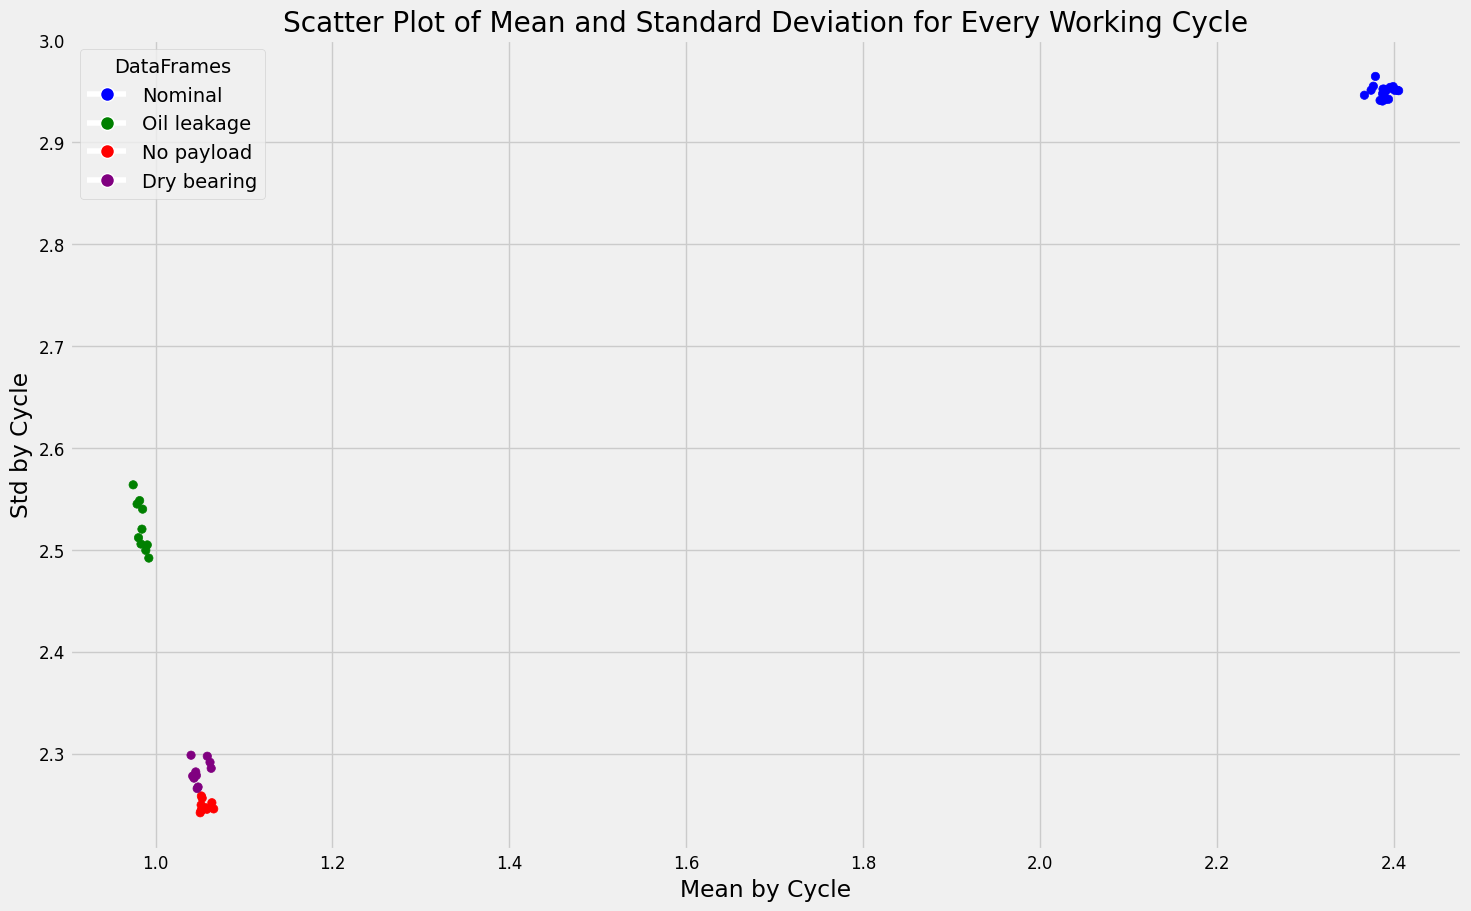

In [391]:
# Funzione che calcola le features
def calculate_values(df):
    grouped_by_cycle = df.groupby('Working_cycle')[['Current_arm2', 'Current_arm3', 'Current_arm4', 'Current_arm5', 'Current_arm6']]
    mean_by_cycle = grouped_by_cycle.mean()
    std_by_cycle = grouped_by_cycle.std()
    result_df = pd.DataFrame({
        'Mean_by_Cycle': mean_by_cycle.mean(axis=1),
        'Std_by_Cycle': std_by_cycle.mean(axis=1)
    })
    return result_df

# Creazione di un unico dataframe composto da caso nominale e casi anomali
result_df_Final = pd.concat([calculate_values(df), calculate_values(df1), calculate_values(df2), calculate_values(df3)], keys=['Nominal', 'Oil leakage', 'No payload', 'Dry bearing'])

# Setting generali e display del grafico scatter plot
colors = {'Nominal': 'blue', 'Oil leakage': 'green', 'No payload': 'red', 'Dry bearing': 'purple'}
plt.scatter(result_df_Final['Mean_by_Cycle'], result_df_Final['Std_by_Cycle'], c=result_df_Final.index.get_level_values(0).map(colors), marker='o')
plt.xlabel('Mean by Cycle')
plt.ylabel('Std by Cycle')
plt.title('Scatter Plot of Mean and Standard Deviation for Every Working Cycle')
legend_labels = {key: f'{key}' for key in colors}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[key], markersize=10, label=legend_labels[key]) for key in colors]
plt.legend(handles=handles, loc='upper left', title='DataFrames')
plt.show()

### Zoom sui casi anomali

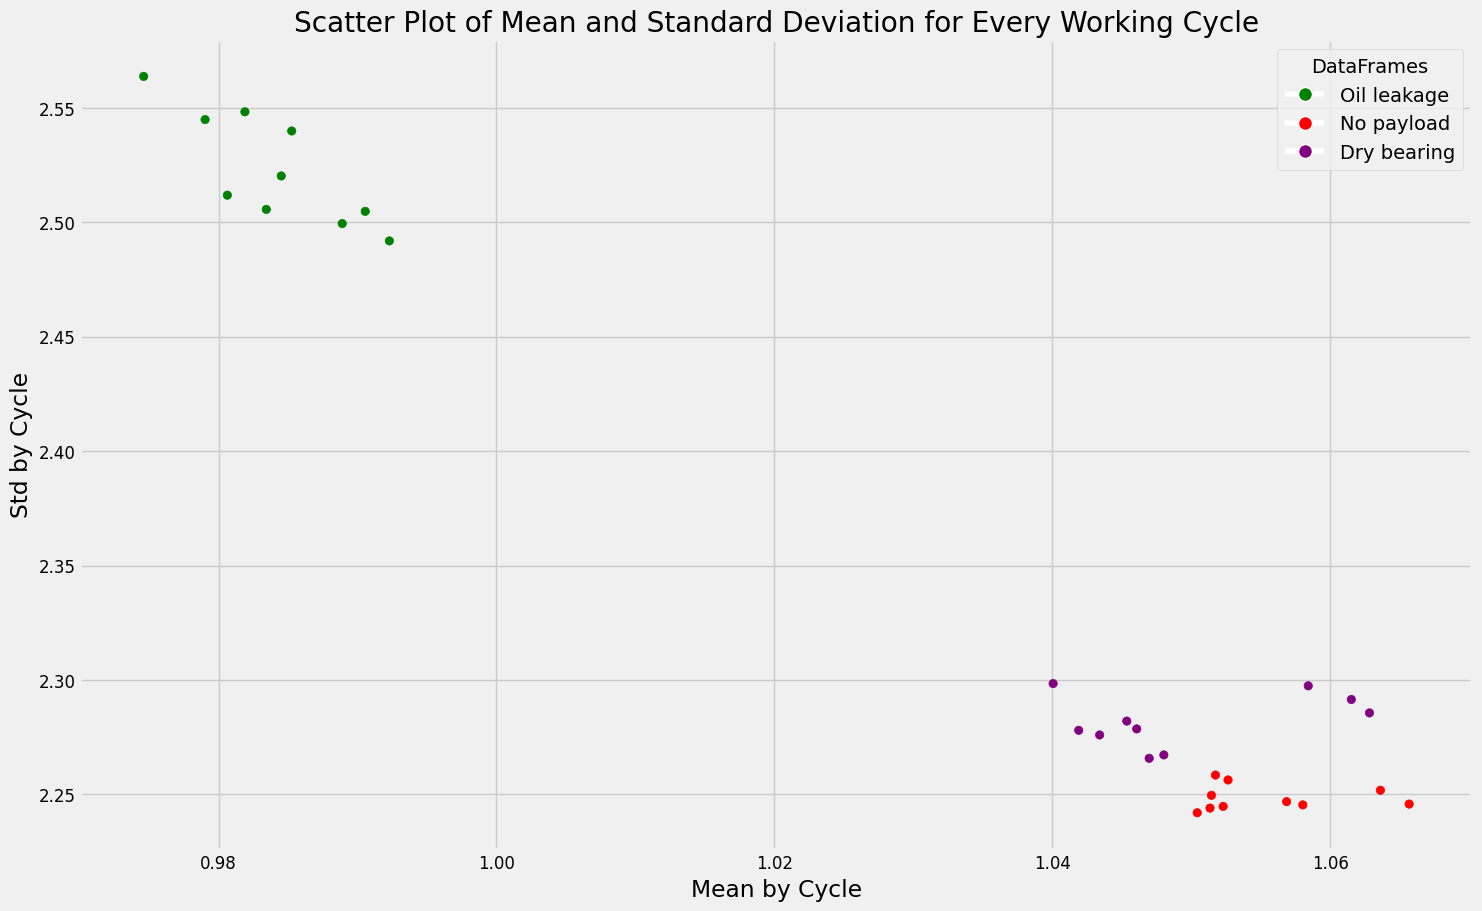

In [392]:
# Creazione di un unico dataframe composto dai soli casi anomali
anomaly_df = pd.concat([calculate_values(df1), calculate_values(df2), calculate_values(df3)], keys=['Oil leakage', 'No payload', 'Dry bearing'])

# Setting e display dello scatter plot per i soli casi anomali
colors = {'Oil leakage': 'green', 'No payload': 'red', 'Dry bearing': 'purple'}
plt.scatter(anomaly_df['Mean_by_Cycle'], anomaly_df['Std_by_Cycle'], c=anomaly_df.index.get_level_values(0).map(colors), marker='o')
plt.xlabel('Mean by Cycle')
plt.ylabel('Std by Cycle')
plt.title('Scatter Plot of Mean and Standard Deviation for Every Working Cycle')
legend_labels = {key: f'{key}' for key in colors}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[key], markersize=10, label=legend_labels[key]) for key in colors]
plt.legend(handles=handles, loc='upper right', title='DataFrames')
plt.show()

### KMeans con media e deviazione standard come features

In [393]:
from sklearn.cluster import KMeans

# Definizione delle features utilizzate
features = ['Mean_by_Cycle', 'Std_by_Cycle']

X = result_df_Final[features]

X_2 = StandardScaler().fit_transform(X)

# Applicazione del KMeans e fitting
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_2)

cluster_labels = kmeans.labels_
# cluster_names_assigned = [cluster_names[label] for label in cluster_labels]
X['Cluster'] = cluster_labels

# Predict dei centroidi
centroids = kmeans.cluster_centers_
sorted_centroids = centroids[np.lexsort(centroids.T)]
centroid_assignments_original = kmeans.predict(sorted_centroids)

# Display del risultato
display(X)

Mean_by_Cycle  Std_by_Cycle  Cluster
            Working_cycle                                      
Nominal     2                    2.40576       2.95054        1
            3                    2.36707       2.94609        1
            4                    2.39062       2.95001        1
            5                    2.39018       2.94320        1
            6                    2.37950       2.96454        1
            7                    2.37719       2.95492        1
            8                    2.39960       2.95455        1
            9                    2.39132       2.95047        1
            10                   2.40123       2.95095        1
            11                   2.38946       2.95198        1
            12                   2.39608       2.95375        1
            13                   2.39726       2.95295        1
            14                   2.37462       2.95100        1
            15                   2.38809       2.95212        1
            16                   2.38753       2.94038        1
            17                   2.38763       2.94755        1
            18                   2.39431       2.94211        1
            19                   2.39081       2.94184        1
            20                   2.38477       2.94102        1
            21                   2.40415       2.95093        1
Oil leakage 2                    0.98344       2.50564        2
            3                    0.99230       2.49187        2
            4                    0.98190       2.54827        2
            5                    0.97903       2.54490        2
            6                    0.99056       2.50478        2
            7                    0.98890       2.49944        2
            8                    0.97462       2.56375        2
            9                    0.98527       2.53990        2
            10                   0.98064       2.51186        2
            11                   0.98452       2.52026        2
No payload  2                    1.06361       2.25179        0
            3                    1.05174       2.25842        0
            4                    1.05145       2.24957        0
            5                    1.06568       2.24573        0
            6                    1.05265       2.25628        0
            7                    1.05043       2.24194        0
            8                    1.05686       2.24681        0
            9                    1.05135       2.24398        0
            10                   1.05229       2.24472        0
            11                   1.05803       2.24538        0
Dry bearing 2                    1.04006       2.29842        3
            3                    1.06152       2.29145        3
            4                    1.04697       2.26574        3
            5                    1.04341       2.27594        3
            6                    1.05842       2.29743        3
            7                    1.04536       2.28201        3
            8                    1.06282       2.28558        3
            9                    1.04190       2.27798        3
            10                   1.04803       2.26722        3
            11                   1.04608       2.27858        3

Da come si puo' vedere dal display precedente l'algoritmo assegna correttamente ogni punto al cluster corrispondente al proprio dataset. <br>
Abbiamo dunque provato a testare il modello sul dataset 'test'.

### KMeans applicato al dataset di testing

display dello scatter plot con media e deviazione standard dopo l'aggiunta del dataset di testing

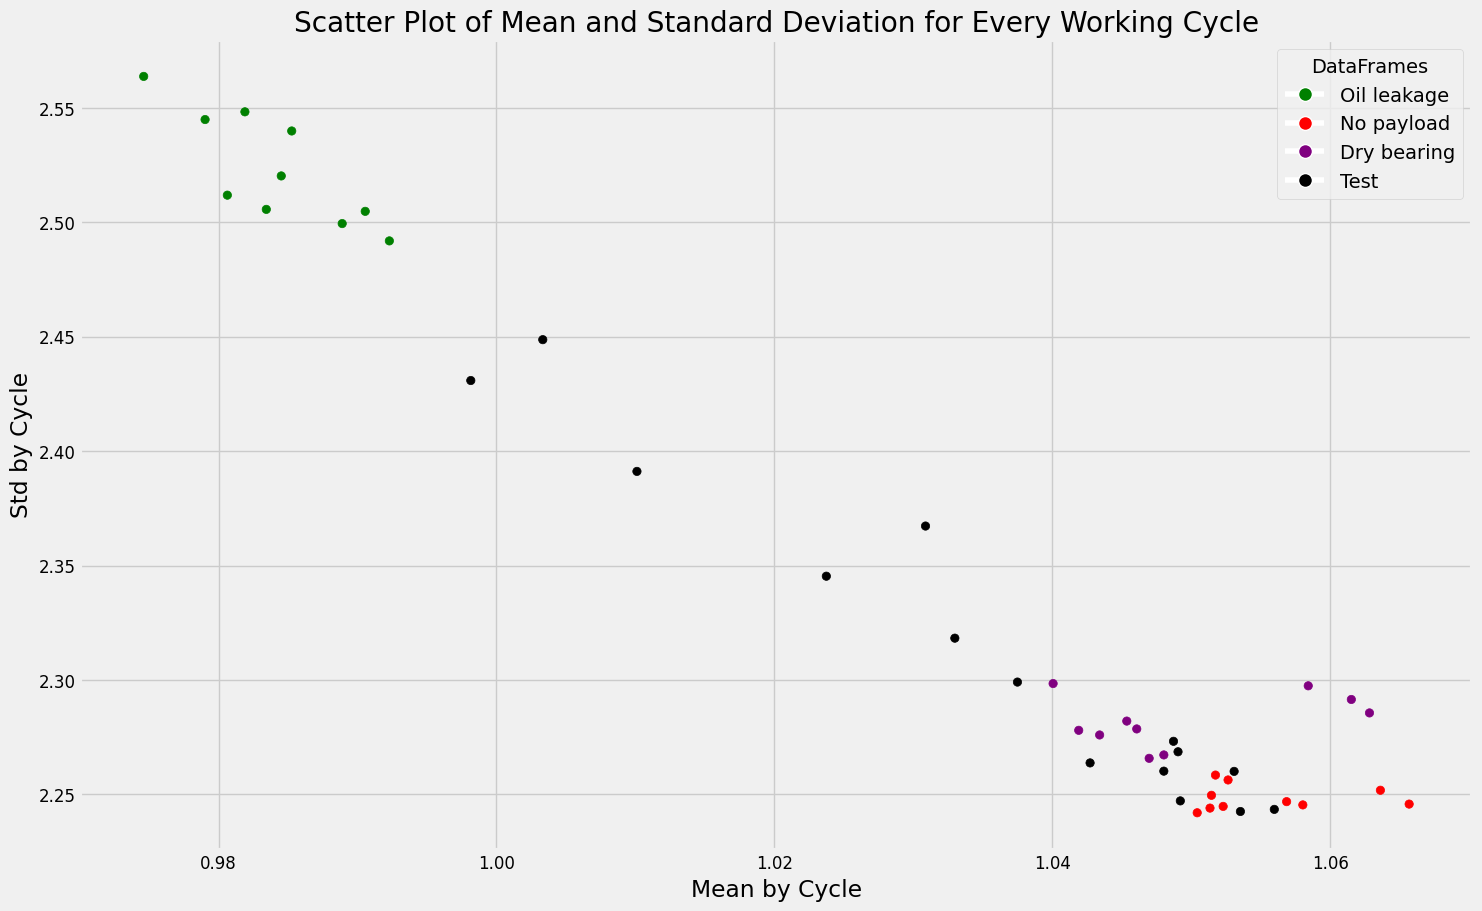

In [394]:
# Creazione di un unico dataframe composto dai casi anomali e il testing
testing_df = pd.concat([calculate_values(df1), calculate_values(df2), calculate_values(df3), calculate_values(dfTest)], keys=['Oil leakage', 'No payload', 'Dry bearing', 'Test'])

# Setting e display dello scatter plot con l'aggiunta del dataset di testing
colors = {'Oil leakage': 'green', 'No payload': 'red', 'Dry bearing': 'purple', 'Test': 'black'}
plt.scatter(testing_df['Mean_by_Cycle'], testing_df['Std_by_Cycle'], c=testing_df.index.get_level_values(0).map(colors), marker='o')
plt.xlabel('Mean by Cycle')
plt.ylabel('Std by Cycle')
plt.title('Scatter Plot of Mean and Standard Deviation for Every Working Cycle')
legend_labels = {key: f'{key}' for key in colors}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[key], markersize=10, label=legend_labels[key]) for key in colors]
plt.legend(handles=handles, loc='upper right', title='DataFrames')
plt.show()

Applicazione del clustering per predictare l'assegnazione dei valori contenuti nel dataset di testing ai cluster corrispondenti

In [395]:
# Filtraggio del dataframe per il solo caso di test
mask = testing_df.index.get_level_values(0) == 'Test'
testing_df_filtered = testing_df[mask]

testing_df_filtered_2 = StandardScaler().fit_transform(testing_df_filtered)

predicted_clusters = kmeans.predict(testing_df_filtered_2)

# predicted_cluster_names_assigned = [predicted_cluster_names[label] for label in predicted_clusters]
testing_df_filtered['Predicted Cluster'] = predicted_clusters

# Display della predizione
display(testing_df_filtered)

Mean_by_Cycle  Std_by_Cycle  Predicted Cluster
     Working_cycle                                                
Test 2                    1.04905       2.26860                  3
     3                    1.04272       2.26373                  3
     4                    1.04921       2.24713                  0
     5                    1.05598       2.24342                  0
     6                    1.04802       2.26013                  3
     7                    1.05354       2.24250                  0
     8                    1.05308       2.26003                  3
     9                    1.04872       2.27317                  3
     10                   1.03749       2.29906                  2
     11                   1.03299       2.31825                  2
     12                   1.02374       2.34533                  2
     13                   1.03088       2.36725                  2
     14                   1.01011       2.39113                  2
     15                   0.99815       2.43084                  2
     16                   1.00333       2.44870                  2

Dall'output si puo' notare come tutti i dati di testing vengano catalogati come casi anomali.

### Cross Validation
Per validare questo risultato abbiamo applicato una cross validation cosi' organizzata per ogni ciclo di iterazione definito inizialmente:
- Da ognuno dei singoli dataset vengono estratti randomicamente un numero n di cicli di lavorazione per ottenere un validation set;
- Viene effettuato un training del modello di clustering su un training set, ottenuto dal dataset originale senza i cicli presenti nel validation set; 
- Viene poi predetto il cluster dei cicli del validation set e del dataset di testing e viene fatta una comparazione tra il risultato previsto e quello ottenuto;
- Infine, viene calcolata e mostrata l'accuratezza media dell'algoritmo rispetto ai validation set.

In [396]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

RealTest = testing_df_filtered.drop(columns='Predicted Cluster')
RealTest = StandardScaler().fit_transform(RealTest)

# Definizione delle variabili
num_clusters = 4
num_iterations = 5
accuracy_scores = []
test_set = pd.DataFrame()

# Ciclo per ogni iterazione
for i in range(num_iterations):

    # Generazione del set di test
    test_set = pd.DataFrame()
    for key in X.index.get_level_values(0).unique():
        dft = X.loc[key]
        sampled_rows = dft.sample(n = 3) # Numero modificabile di campioni da estrarre
        sampled_rows.index = pd.MultiIndex.from_product([[key], sampled_rows.index])
        test_set = pd.concat([test_set, sampled_rows])

    # Divisione del dataset in train e test
    train_set = X.drop(test_set.index)
    true_labels_test = test_set['Cluster']
    X_train = train_set.drop(columns=['Cluster'])
    X_test = test_set.drop(columns=['Cluster'])

    # Training del modello KMeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    
    X_train_2 = StandardScaler().fit_transform(X_train)
    kmeans.fit(X_train_2)

    centroids = kmeans.cluster_centers_
    sorted_centroids = centroids[np.lexsort(centroids.T)]
    centroid_assignments = kmeans.predict(sorted_centroids)
    
    X_test_2 = StandardScaler().fit_transform(X_test)

    # Predizione dei cluster sui dataset
    predictions = kmeans.predict(X_test_2)
    predictionsTest = kmeans.predict(RealTest)

    # Eventuale aggiornamento delle predizioni basate sulla modifica dei centroidi
    if not np.array_equal(centroid_assignments_original, centroid_assignments):
        diff_indices = np.where(centroid_assignments_original != centroid_assignments)[0]
        for index1, element1 in enumerate(predictions):
            for index2, element2 in enumerate(diff_indices):
                if element1 == centroid_assignments[element2]:
                    predictions[index1] = centroid_assignments_original[element2]
                    break

    if not np.array_equal(centroid_assignments_original, centroid_assignments):
        diff_indices = np.where(centroid_assignments_original != centroid_assignments)[0]
        for index1, element1 in enumerate(predictionsTest):
            for index2, element2 in enumerate(diff_indices):
                if element1 == centroid_assignments[element2]:
                    predictionsTest[index1] = centroid_assignments_original[element2]
                    break

    # Calcolo dell'accuratezza della singola iterazione
    accuracy = accuracy_score(true_labels_test, predictions)

    # Display dei risultati ottenuti
    print('Estrazione di n cicli dai singoli dataset:')
    display(true_labels_test)

    print('Assegnazione degli n cicli ai cluster:')
    display(predictions)

    print('Previsione del dataset di testing:')
    display(predictionsTest)
    print('------------------------------------------------------------------\n')

    accuracy_scores.append(accuracy)

# Calcolo dell'accuratezza media di tutte le iterazioni
average_accuracy = sum(accuracy_scores) / num_iterations
display(f'Average Accuracy: {average_accuracy}')

Estrazione di n cicli dai singoli dataset:


             Working_cycle
Nominal      18               1
             20               1
             16               1
Oil leakage  4                2
             11               2
             10               2
No payload   2                0
             9                0
             6                0
Dry bearing  9                3
             2                3
             11               3
Name: Cluster, dtype: int32

Assegnazione degli n cicli ai cluster:


array([1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3], dtype=int32)

Previsione del dataset di testing:


array([3, 3, 3, 3, 3, 3, 1, 3, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

------------------------------------------------------------------

Estrazione di n cicli dai singoli dataset:


             Working_cycle
Nominal      15               1
             17               1
             14               1
Oil leakage  9                2
             7                2
             3                2
No payload   7                0
             8                0
             2                0
Dry bearing  10               3
             4                3
             11               3
Name: Cluster, dtype: int32

Assegnazione degli n cicli ai cluster:


array([1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3], dtype=int32)

Previsione del dataset di testing:


array([3, 3, 3, 3, 3, 3, 1, 3, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

------------------------------------------------------------------

Estrazione di n cicli dai singoli dataset:


             Working_cycle
Nominal      15               1
             11               1
             6                1
Oil leakage  7                2
             8                2
             4                2
No payload   11               0
             2                0
             6                0
Dry bearing  6                3
             10               3
             3                3
Name: Cluster, dtype: int32

Assegnazione degli n cicli ai cluster:


array([1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3], dtype=int32)

Previsione del dataset di testing:


array([3, 3, 3, 0, 3, 0, 1, 3, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

------------------------------------------------------------------

Estrazione di n cicli dai singoli dataset:


             Working_cycle
Nominal      12               1
             3                1
             14               1
Oil leakage  11               2
             10               2
             9                2
No payload   9                0
             2                0
             3                0
Dry bearing  3                3
             2                3
             11               3
Name: Cluster, dtype: int32

Assegnazione degli n cicli ai cluster:


array([1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3], dtype=int32)

Previsione del dataset di testing:


array([3, 3, 3, 0, 3, 0, 1, 3, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

------------------------------------------------------------------

Estrazione di n cicli dai singoli dataset:


             Working_cycle
Nominal      10               1
             3                1
             5                1
Oil leakage  6                2
             4                2
             9                2
No payload   10               0
             7                0
             4                0
Dry bearing  3                3
             10               3
             9                3
Name: Cluster, dtype: int32

Assegnazione degli n cicli ai cluster:


array([1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3], dtype=int32)

Previsione del dataset di testing:


array([3, 3, 3, 0, 3, 0, 1, 3, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

------------------------------------------------------------------



'Average Accuracy: 0.75'

Il valore dell'accuratezza media non e' costante, ma varia ad ogni esecuzione della cross validation, ed in particolare diminuisce all'aumentare del numero n di cicli di lavorazione estratti dai dataset originali. Abbiamo notato, inoltre, che ad ogni iterazione del cross validation le previsioni sul dataset di testing non sono costanti.

Queste osservazioni ci hanno portato alla conclusione dell'inaffidabilita' del modello attuale. Abbiamo deciso dunque di aggiungere nuove features oltre alla media e alla deviazione standard per descrivere in maniera piu' completa ogni ciclo di lavorazione.

### Aggiunta di nuove features

Valutando tra loro le grandezze statistiche derivate dal dataset nominale e dai tre dataset descriventi casi anomali, si e' notato che le grandezze piu' rilevanti sono state il range, la kurtosis e la skewness: in particolare si e' preso in considerazione il range e la kurtosis relativi a Current_arm4, perche' quest'ultima assume una forbice di valori maggiore rispetto alle altre, e la skewness relativa a Current_arm2 per la stessa motivazione.

In [401]:
# Definizione delle colonne
column_names = ['Nominal', 'Oil leakage', 'No payload', 'Dry bearing']

range_df.columns = column_names
kurtosis_df.columns = column_names
skewness_df.columns = column_names

# Creazione dei dataframe con evidenziate in rosso le righe corrispondenti alle variabili ritenute interessanti
highlighted_range_df = range_df.iloc[1:6].style.apply(lambda x: ['background: red' if x.name == 'Current_arm4' else '' for i in x], axis=1)
highlighted_kurtosis_df = kurtosis_df.iloc[1:6].style.apply(lambda x: ['background: red' if x.name == 'Current_arm4' else '' for i in x], axis=1)
highlighted_skewness_df = skewness_df.iloc[1:6].style.apply(lambda x: ['background: red' if x.name == 'Current_arm2' else '' for i in x], axis=1)

# Display dei dataframe
print("\nSide-by-Side Comparison of Range:")
display(highlighted_range_df)

print("\nSide-by-Side Comparison of Kurtosis:")
display(highlighted_kurtosis_df)

print("\nSide-by-Side Comparison of Skewness:")
display(highlighted_skewness_df)


Side-by-Side Comparison of Range:


,Nominal,Oil leakage,No payload,Dry bearing
Current_arm2,50.422300,50.497900,41.293500,41.312100
Current_arm3,41.713800,34.916100,34.823400,34.816100
Current_arm4,15.155000,6.996900,7.018800,7.919200
Current_arm5,6.517600,5.064400,5.066400,5.068600
Current_arm6,4.730700,3.962400,3.935100,3.944000



Side-by-Side Comparison of Kurtosis:


,Nominal,Oil leakage,No payload,Dry bearing
Current_arm2,1.800873,2.444886,3.356061,3.424080
Current_arm3,7.997271,4.981435,4.977601,4.974249
Current_arm4,1.807118,1.298541,1.286464,0.573538
Current_arm5,2.308825,1.448463,1.430958,1.478915
Current_arm6,0.628999,0.617190,0.602622,0.641174



Side-by-Side Comparison of Skewness:


,Nominal,Oil leakage,No payload,Dry bearing
Current_arm2,-0.164995,-0.165104,-0.018643,-0.005848
Current_arm3,-0.519303,-0.085938,-0.083338,-0.085073
Current_arm4,0.941013,-0.240240,-0.239031,-0.188543
Current_arm5,0.592513,-0.514221,-0.513910,-0.498748
Current_arm6,0.755335,-0.090665,-0.092685,-0.089787


### Riapplicazione del modello KMeans con le nuove features

In [398]:
from sklearn.cluster import KMeans

# Funzione che calcola le nuove features
def calculate_fvalues(df):
    grouped_by_cycle = df.groupby('Working_cycle')[['Current_arm2', 'Current_arm3', 'Current_arm4', 'Current_arm5', 'Current_arm6']]
    mean_by_cycle = grouped_by_cycle.mean()
    std_by_cycle = grouped_by_cycle.std()
    range_by_cycle = df.groupby('Working_cycle')[['Current_arm4']].max() - df.groupby('Working_cycle')[['Current_arm4']].min()
    kurtosis_by_cycle = df.groupby('Working_cycle')[['Current_arm4']].apply(pd.DataFrame.kurt)
    skewness_by_cycle = df.groupby('Working_cycle')[['Current_arm2']].apply(pd.DataFrame.skew)
    fresult_df = pd.DataFrame({
        'Mean_by_Cycle': mean_by_cycle.mean(axis=1),
        'Std_by_Cycle': std_by_cycle.mean(axis=1),
        'Range_by_Cycle': range_by_cycle.mean(axis=1),
        'Skewness_by_Cycle': skewness_by_cycle.mean(axis=1),
        'Kurtosis_by_Cycle': kurtosis_by_cycle.mean(axis=1),
    })
    return fresult_df

# Creazione di un unico dataframe composto dal caso nominale e dai casi anomali
features_df_Final = pd.concat([calculate_fvalues(df), calculate_fvalues(df1), calculate_fvalues(df2), calculate_fvalues(df3)], keys=['Nominal', 'Oil leakage', 'No payload', 'Dry bearing'])

# Definizione delle nuove features
new_features = ['Mean_by_Cycle', 'Std_by_Cycle', 'Range_by_Cycle', 'Skewness_by_Cycle', 'Kurtosis_by_Cycle']

F = features_df_Final[new_features]
F_2 = StandardScaler().fit_transform(F)

# Applicazione del KMeans e fitting
fkmeans = KMeans(n_clusters=4, random_state=42)
fkmeans.fit(F_2)

fcluster_labels = fkmeans.labels_
F['Cluster'] = fcluster_labels

# Predizione dei centroidi
fcentroids = fkmeans.cluster_centers_
fsorted_centroids = fcentroids[np.lexsort(fcentroids.T)]
centroid_assignments_features = fkmeans.predict(fsorted_centroids)

# Display del risultato
display(F)

Mean_by_Cycle  Std_by_Cycle  Range_by_Cycle  Skewness_by_Cycle  Kurtosis_by_Cycle  Cluster
            Working_cycle                                                                                            
Nominal     2                    2.40576       2.95054        15.06810           -0.18623            1.82601        0
            3                    2.36707       2.94609        15.09010           -0.12657            1.86365        0
            4                    2.39062       2.95001        14.97090           -0.16577            1.75931        0
            5                    2.39018       2.94320        15.01270           -0.16542            1.90017        0
            6                    2.37950       2.96454        15.03060           -0.16212            1.77063        0
            7                    2.37719       2.95492        15.02020           -0.15814            1.78670        0
            8                    2.39960       2.95455        14.99480           -0.17960            1.86177        0
            9                    2.39132       2.95047        15.00750           -0.16628            1.77993        0
            10                   2.40123       2.95095        15.14030           -0.18602            1.83296        0
            11                   2.38946       2.95198        15.06820           -0.16216            1.79814        0
            12                   2.39608       2.95375        15.08030           -0.17425            1.81518        0
            13                   2.39726       2.95295        15.00120           -0.17953            1.79374        0
            14                   2.37462       2.95100        15.00380           -0.14205            1.79174        0
            15                   2.38809       2.95212        15.01940           -0.16299            1.80052        0
            16                   2.38753       2.94038        15.07250           -0.15841            1.77842        0
            17                   2.38763       2.94755        15.09100           -0.15898            1.80018        0
            18                   2.39431       2.94211        14.97820           -0.16638            1.78875        0
            19                   2.39081       2.94184        14.97890           -0.15932            1.81041        0
            20                   2.38477       2.94102        14.99350           -0.16452            1.84119        0
            21                   2.40415       2.95093        14.90700           -0.17526            1.76486        0
Oil leakage 2                    0.98344       2.50564         6.95920           -0.15308            1.28606        2
            3                    0.99230       2.49187         6.98310           -0.15807            1.30754        2
            4                    0.98190       2.54827         6.97110           -0.17502            1.29548        2
            5                    0.97903       2.54490         6.99260           -0.17058            1.29563        2
            6                    0.99056       2.50478         6.95110           -0.16042            1.31266        2
            7                    0.98890       2.49944         6.97260           -0.15978            1.30923        2
            8                    0.97462       2.56375         6.97100           -0.17273            1.31340        2
            9                    0.98527       2.53990         6.98300           -0.17778            1.32223        2
            10                   0.98064       2.51186         6.98580           -0.14840            1.25261        2
            11                   0.98452       2.52026         6.94680           -0.16556            1.29671        2
No payload  2                    1.06361       2.25179         7.01880           -0.02574            1.27565        3
            3                    1.05174       2.25842         7.00470           -0.01679            1.23929        3
            4  

### Predict sul dataset di testing con il nuovo modello

In [399]:
# Creazione di un unico dataframe composto dai casi anomali e il test
features_df = pd.concat([calculate_fvalues(df1), calculate_fvalues(df2), calculate_fvalues(df3), calculate_fvalues(dfTest)], keys=['Oil leakage', 'No payload', 'Dry bearing', 'Test'])

# Filtraggio del nuovo dataframe combinato
new_mask = features_df.index.get_level_values(0) == 'Test'
features_df_filtered = features_df[new_mask]\

features_df_filtered_2 = StandardScaler().fit_transform(features_df_filtered)
# Predizione dei cluster
predicted_fclusters = fkmeans.predict(features_df_filtered_2)

features_df_filtered['Predicted Cluster'] = predicted_fclusters

print(features_df_filtered)

                    Mean_by_Cycle  Std_by_Cycle  Range_by_Cycle  Skewness_by_Cycle  Kurtosis_by_Cycle  Predicted Cluster
     Working_cycle                                                                                                      
Test 2                    1.04905       2.26860         6.98260           -0.03111            1.30385                  3
     3                    1.04272       2.26373         6.98690           -0.02035            1.33392                  3
     4                    1.04921       2.24713         6.95210           -0.01583            1.30748                  3
     5                    1.05598       2.24342         6.98020           -0.01980            1.30862                  3
     6                    1.04802       2.26013         6.99140           -0.02012            1.27687                  1
     7                    1.05354       2.24250         6.97630           -0.00793            1.34332                  3
     8                    1.0530

Come si puo' vedere dall'output, anche con l'aggiunta di nuove features tutti i cicli del dataset di testing vengono catalogati come casi anomali, ma a differenza del caso precedente, questi vengono suddivisi solamente tra i casi 'No payload' e 'Oil leakage'.

### Applicazione della Cross Validation sulla nuova predizione

In [400]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

RealTest = features_df_filtered.drop(columns='Predicted Cluster')

RealTest = StandardScaler().fit_transform(RealTest)

# Setting delle variabili
num_clusters = 4
num_iterations = 5
accuracy_scores = []
test_set = pd.DataFrame()

# Ciclo per ogni iterazione
for i in range(num_iterations):
    test_set = pd.DataFrame()
    # Estrazione randomica di n campioni
    for key in F.index.get_level_values(0).unique():
        dft = F.loc[key]
        sampled_rows = dft.sample(n = 3)  # Numero modificabile di campioni estratti
        sampled_rows.index = pd.MultiIndex.from_product([[key], sampled_rows.index])
        test_set = pd.concat([test_set, sampled_rows])

    # Aggiunta e rimozione di colonne
    train_set = F.drop(test_set.index)
    true_labels_test = test_set['Cluster']
    F_train = train_set.drop(columns=['Cluster'])
    F_test = test_set.drop(columns=['Cluster'])


    # Applicazione e fitting dell'algoritmo
    final_kmeans = KMeans(n_clusters=num_clusters, random_state=42)

    F_train_2 = StandardScaler().fit_transform(F_train)
    
    final_kmeans.fit(F_train_2)

    # Calcolo e predict sui centroidi
    centroids = final_kmeans.cluster_centers_
    sorted_centroids = centroids[np.lexsort(centroids.T)]
    centroid_assignments = final_kmeans.predict(sorted_centroids)

    # Predizione sul test

    F_test_2 = StandardScaler().fit_transform(F_test)

    predictions = final_kmeans.predict(F_test_2)

    # Predizione sul campione reale
    predictionsTest = final_kmeans.predict(RealTest)

    # Controllo di una eventuale discrepanza e conseguente aggiornamento della posizione dei centroidi rispetto all'iterazione precedente 
    if not np.array_equal(centroid_assignments_features, centroid_assignments):
        diff_indices = np.where(centroid_assignments_features != centroid_assignments)[0]
        for index1, element1 in enumerate(predictions):
            for index2, element2 in enumerate(diff_indices):
                if element1 == centroid_assignments[element2]:
                    predictions[index1] = centroid_assignments_features[element2]
                    break
    
    # Stesso controllo ma per 'predictionsTest'
    if not np.array_equal(centroid_assignments_features, centroid_assignments):
        diff_indices = np.where(centroid_assignments_features != centroid_assignments)[0]
        for index1, element1 in enumerate(predictionsTest):
            for index2, element2 in enumerate(diff_indices):
                if element1 == centroid_assignments[element2]:
                    predictionsTest[index1] = centroid_assignments_features[element2]
                    break
    
    # Calcolo dell'accuratezza della singola iterazione
    accuracy = accuracy_score(true_labels_test, predictions)
    accuracy_scores.append(accuracy)

    # Display dei risultati
    display(true_labels_test)
    display(predictions)
    display(predictionsTest)


# Calcolo e display dell'accuratezza media dell'algoritmo
average_accuracy = sum(accuracy_scores) / num_iterations
print(f'Average Accuracy: {average_accuracy}')


             Working_cycle
Nominal      6                0
             5                0
             20               0
Oil leakage  7                2
             10               2
             4                2
No payload   4                3
             7                3
             11               3
Dry bearing  6                1
             10               1
             8                1
Name: Cluster, dtype: int32

array([0, 0, 0, 2, 2, 2, 3, 3, 3, 1, 1, 1], dtype=int32)

array([3, 0, 3, 3, 1, 3, 0, 0, 2, 2, 2, 0, 2, 2, 2], dtype=int32)

             Working_cycle
Nominal      2                0
             12               0
             4                0
Oil leakage  8                2
             10               2
             7                2
No payload   4                3
             10               3
             9                3
Dry bearing  3                1
             4                1
             2                1
Name: Cluster, dtype: int32

array([0, 0, 0, 2, 2, 2, 3, 3, 3, 1, 1, 1], dtype=int32)

array([3, 0, 3, 3, 1, 3, 0, 0, 2, 2, 2, 0, 2, 2, 2], dtype=int32)

             Working_cycle
Nominal      16               0
             7                0
             9                0
Oil leakage  10               2
             2                2
             8                2
No payload   5                3
             9                3
             2                3
Dry bearing  8                1
             3                1
             10               1
Name: Cluster, dtype: int32

array([0, 0, 0, 2, 2, 2, 3, 3, 3, 1, 1, 1], dtype=int32)

array([3, 0, 3, 3, 1, 3, 0, 0, 2, 2, 2, 0, 2, 2, 2], dtype=int32)

             Working_cycle
Nominal      8                0
             19               0
             21               0
Oil leakage  5                2
             6                2
             7                2
No payload   6                3
             9                3
             4                3
Dry bearing  4                1
             2                1
             5                1
Name: Cluster, dtype: int32

array([0, 0, 0, 2, 2, 2, 3, 3, 3, 1, 1, 1], dtype=int32)

array([3, 0, 3, 3, 1, 3, 0, 0, 2, 2, 2, 0, 2, 2, 2], dtype=int32)

             Working_cycle
Nominal      2                0
             15               0
             21               0
Oil leakage  4                2
             5                2
             7                2
No payload   2                3
             5                3
             7                3
Dry bearing  11               1
             4                1
             7                1
Name: Cluster, dtype: int32

array([0, 0, 0, 2, 2, 2, 3, 3, 3, 1, 1, 1], dtype=int32)

array([3, 0, 3, 3, 1, 3, 0, 0, 2, 2, 2, 0, 2, 2, 2], dtype=int32)

Average Accuracy: 1.0


## Osservazioni finali:

Dalla riapplicazione del modello KMeans con le nuove features abbiamo notato un miglioramento generale dell'accuratezza media dell'algoritmo. <br>
Con l'adozione delle features media, deviazione standard, range, kurtosis e skewness l'algoritmo mantiene prossima a 1 l'accuratezza media. <br>
L'algoritmo e' in grado di performare bene anche all'aumentare del numero n di campioni estratti dal dataset di testing (avendo quindi meno campioni disponibili da utilizzare come punto di partenza per l'analisi). <br>
L'accuratezza inizia a scendere quando n >= 5, ovvero quando il numero di campione si dimezza.